<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural

## Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

## 1 - Descarga del dataset

In [1]:
# En las versiones modernas de Keras y TensorFlow, keras.preprocessing.text ya viene incluido.
# Si necesitas instalar keras, puedes hacerlo con:
!pip install keras-preprocessing


  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl.metadata (1.9 kB)
Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)


In [2]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf

# from keras.preprocessing.text import one_hot
# from tensorflow.keras.utils import pad_sequences
# from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
# from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.utils import plot_model



from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

2025-08-24 13:45:12.815486: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-24 13:45:12.891592: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-24 13:45:12.954131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756061113.031769  144651 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756061113.049694  144651 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756061113.188010  144651 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
# Descargar la carpeta de dataset

import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /home/marck/Documents/UBA/PLN_I_Procesamiento_de_Lenguaje_Natural/Desafios_Procesamiento_Lenguaje_natural/desafio_4/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 3.99MB/s]


## 2 - Preprocesamiento

In [4]:
# Creación del dataset
import json


text_file = "data_volunteers.json"

with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30
MIN_SALUTE_LENGTH = 4

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for cell in data:
    for i in range(len(cell['dialog'])-1):
        raw_line = cell['dialog'][i]['text']
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(cell['dialog'][i]['text'])
        chat_out = clean_text(cell['dialog'][i+1]['text'])

        # Mantenerla solo si posee cierre de interrogación '?'
        if raw_line.find('?') < 0:
            continue

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out


        # modificación del mensaje
        if len(raw_line) < MIN_SALUTE_LENGTH:
          input_sentence, output = chat_in, clean_text("Hello, how are you today?")


        for sub_question in raw_line.split('.'):
          if raw_line.find('?') < 0:
            continue

          sub_input = sub_question
          sub_output = output

          input_sentences.append(sub_input)
          output_sentences.append(output + ' <eos>')
          output_sentences_inputs.append('<sos> ' + output)


        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles:", len(data))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 1111
Cantidad de rows utilizadas: 3680


In [49]:
for i in range(10):
  # Formato PREGUNTA, RESPUESTA, RESPUESTA TEACHER FORCING
  print(f"PREGUNTA: {input_sentences[i]}\n\t{output_sentences[i]}\n\t{output_sentences_inputs[i]}")

PREGUNTA: Hi! How are you?
	not bad and you  <eos>
	<sos> not bad and you 
PREGUNTA: hi how are you 
	not bad and you  <eos>
	<sos> not bad and you 
PREGUNTA: Where are you working?
	bro  <eos>
	<sos> bro 
PREGUNTA: where are you working 
	bro  <eos>
	<sos> bro 
PREGUNTA: Bro?
	where are you from  <eos>
	<sos> where are you from 
PREGUNTA: bro 
	where are you from  <eos>
	<sos> where are you from 
PREGUNTA: Where are you from? 
	i am from russia and you  <eos>
	<sos> i am from russia and you 
PREGUNTA: where are you from 
	i am from russia and you  <eos>
	<sos> i am from russia and you 
PREGUNTA: I'am from Russia
	i am from the united states  <eos>
	<sos> i am from the united states 
PREGUNTA:  And you?
	i am from the united states  <eos>
	<sos> i am from the united states 


In [6]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

In [7]:

special_chars = '!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n'

def print_dict(dictionary):
  if len(dictionary) == 0:
    print("The dictionary is empty.")
  else:
    for key, value in dictionary.items():
      print(f"{key}: {value}")

def find_special_chars(senteces_array, special_chars):
  sentences_with_special_char = {}

  for i in range(len(senteces_array)):
    sentence = senteces_array[i]
    for char in special_chars:

      if char in sentence:
        sentences_with_special_char[i] = sentence
        break

  return sentences_with_special_char

In [8]:
print_dict(find_special_chars(input_sentences, special_chars))


0: Hi! How are you?
2: Where are you working?
4: Bro?
6: Where are you from? 
9:  And you?
11: What is your favorite?
14:  Do you?
16: hello! how are you doing? 
18: What is tacos then?
20: Who are you?
22: Cool! Where are you from?
25:  What genre? 
27: Oh, where are you from then?
29: What happened?
31: Whanna know more?
33: What team do you like?
35: Oh, yeah? 
37: Do you have any pets?
40:  And you?
42: Cool! How old is she?
44: So old?! Is it possible?
46: What about you?
48: What is yours?
50: Where are you?
52: What are u good in?
54: What do you do? 
56: Where do you live? 
58: What are your plans?
60: Hey there, how are you?
62: I'am fine! And you?
64: I'm doing well, how are you?
66: how are you ?
68: I am doing well, how are you?
70: What do you do for a living?
72: whats up ?
74: Hello there, how are you?
76: What's your name?
79:  How are you?
81: Hey! Where are you?
83: What's going on?
85: Hello how are you today?
87: What do you do for work?
89: I'm an it engeneer and y

In [9]:
input_sentences[573], output_sentences[573], output_sentences_inputs[573]


('Ciao, how do you do?', 'hello  <eos>', '<sos> hello ')

In [10]:
# # Eliminar el indice 573 de las listas
# del input_sentences[573]
# del output_sentences[573]
# del output_sentences_inputs[573]

# print("Cantidad de rows utilizadas después de eliminar el indice 573:", len(input_sentences))

In [11]:
input_sentences[575], output_sentences[575], output_sentences_inputs[575]

('bonjour mon ami?',
 'contour how are you today  <eos>',
 '<sos> contour how are you today ')

In [12]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

In [13]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
# from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

# tokenizador de inglés
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 563
Sentencia de entrada más larga: 8


In [14]:
print_dict(find_special_chars(output_sentence, special_chars))


The dictionary is empty.


In [15]:
print_dict(find_special_chars(output_sentences_inputs, special_chars))

The dictionary is empty.


In [16]:
# tokenizador de español
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
# Se suma 1 para incluir el token de palabra desconocida

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 958
Sentencia de salida más larga: 9


A la hora de realiza padding es importante tener en cuenta que en el encoder los ceros se agregan al comienzo y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [17]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 3680
encoder_input_sequences shape: (3680, 8)
decoder_input_sequences shape: (3680, 9)


La última capa del modelo (softmax) necesita que los valores de salida
del decoder (decoder_sequences) estén en formato oneHotEncoder.\
Se utiliza "decoder_output_sequences" con la misma estrategia con que se transformó la entrada del decoder.

In [18]:
from keras.utils import to_categorical
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(3680, 9, 959)

## 3 - Preparar los embeddings

In [19]:
# Descargar los embeddings desde un google drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque de código
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/u/0/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Downloading...
From (original): https://drive.google.com/u/0/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94
From (redirected): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&confirm=t&uuid=887b7666-7dfd-4972-a2e7-b70eeb247196
To: /home/marck/Documents/UBA/PLN_I_Procesamiento_de_Lenguaje_Natural/Desafios_Procesamiento_Lenguaje_natural/desafio_4/gloveembedding.pkl
100%|██████████| 525M/525M [00:44<00:00, 11.8MB/s] 


In [20]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [21]:
# Por una cuestion de RAM se utilizarán los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [32]:
# Crear la Embedding matrix de las secuencias
# en inglés

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provienen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) +1 # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 19


In [33]:
# Dimensión de los embeddings de la secuencia en inglés
embedding_matrix.shape

(564, 50)

## 4 - Entrenar el modelo

In [34]:
max_input_len

8

In [78]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

n_units = 200

# define training encoder
encoder_inputs = Input(shape=(max_input_len,))

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 8, 50)     │     28,200 │ input_layer_14[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 9, 200)    │    191,800 │ input_layer_15[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ [(None, 200),     │    200,800 │ embedding_8[0][0] │
│                     │ (None, 200),      │            │                   │
│                     │ (None, 200)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ [(None, 9, 200),  │    320,800 │ embedding_9[0][0… │
│                     │ (None, 200),      │            │ lstm_8[0][1],     │
│                     │ (None, 200)]      │            │ lstm_8[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 9, 959)    │    192,759 │ lstm_9[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 934,359 (3.56 MB)

 Trainable params: 906,159 (3.46 MB)

 Non-trainable params: 28,200 (110.16 KB)

In [79]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [80]:
# ENTRENAMIENTO

hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=50,
    validation_split=0.2)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.5764 - loss: 2.8438 - val_accuracy: 0.6341 - val_loss: 2.2732
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6402 - loss: 2.0720 - val_accuracy: 0.6529 - val_loss: 2.1247
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6671 - loss: 1.8551 - val_accuracy: 0.6757 - val_loss: 1.9978
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6907 - loss: 1.6870 - val_accuracy: 0.6979 - val_loss: 1.9299
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7103 - loss: 1.5568 - val_accuracy: 0.7095 - val_loss: 1.8871
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7214 - loss: 1.4532 - val_accuracy: 0.7148 - val_loss: 1.8630
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7306 - loss: 1.3662 - val_accuracy: 0.7207 - val_loss: 1.8464
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7391 - loss: 1.2902 - val_accuracy: 0.7181 - v

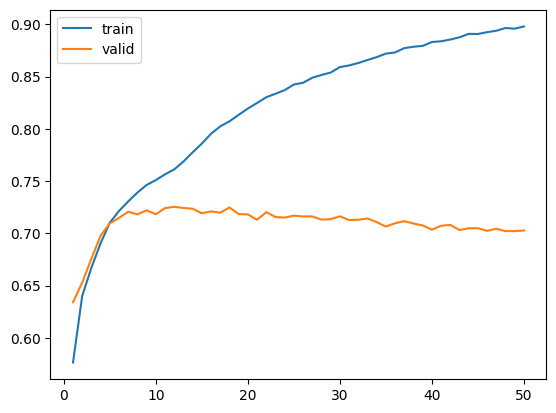

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

## 5 - Inferencia

In [82]:
'''
Step 1:
A deal is a deal -> Encoder -> enc(h1,c1)

enc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)

step 2:
dec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)

step 3:
dec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)

step 4:
dec(h3,c3) + es -> Decoder -> un + dec(h4,c4)

step 5:
dec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)

step 6:
dec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)
'''

'\nStep 1:\nA deal is a deal -> Encoder -> enc(h1,c1)\n\nenc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)\n\nstep 2:\ndec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)\n\nstep 3:\ndec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)\n\nstep 4:\ndec(h3,c3) + es -> Decoder -> un + dec(h4,c4)\n\nstep 5:\ndec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)\n\nstep 6:\ndec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)\n'

In [83]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [84]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

In [85]:
# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)


In [86]:

def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [104]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
-
Input: oh okay 
Response: no


In [88]:
input_seq

array([[ 0,  0,  0, 12,  7,  4,  1, 24]], dtype=int32)

In [89]:
input_test = "My mother say hi"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: My mother say hi
Representacion en vector de tokens de ids [148, 474, 102, 22]
Padding del vector: [[  0   0   0   0 148 474 102  22]]
Input: My mother say hi


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Response: i have two i have two


In [90]:
# Predicción usando RNN con GRU
import gradio as gr

def model_response_GRU(human_text):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    integer_seq_test = input_tokenizer.texts_to_sequences([human_text])[0]
    encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)


    states_value = encoder_model.predict(encoder_sequence_test)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

iface = gr.Interface(
    fn=model_response_GRU,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


## 6 - Conclusiones

- Se logró entrenar un modelo ecoder-decorder para respoder a secuencias de palabras en inglés.
- Aunque se relizó una limpieza más exhaustiva del dataset, las respuestas no siempre mantienen coherencia. Esto se prodría mejorar agregando más datos con un contexto más enriquecido